## Assignment 8

### Correlation picking

In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from setupFigure import SetupFigure
from dftFast import dft_fast_coeff, dft_fast_synthesis
from seismicTrace import SeismicTrace

#### You may use this function for the Butterworth lowpass filter (or your own from Assignment 6)

In [38]:
def butterworth_lowpass(fc, df, nf, order):
    """
    Calculates samples of the lowpass Butterworth filter transfer function (positive frequencies only)
    :param fc: corner frequency in Hz
    :param df: frequency stepping in Hz
    :param nf: number of frequencies
    :param order: filter order
    """
    f = df*np.arange(0, nf)
    h = np.ones(nf, dtype=np.complex64)
    for k in range(order):
        arg = 1j*(2*k+1)*np.pi/(2*order)
        h = h*(-1j)/(f/fc-np.exp(arg))
    return h

#### This is a useful function to plot traces next to each other with a vertical offset

In [39]:
def plotTraceGather(tracelist, ax):
    """
    Plots a gather of traces with vertical offset
    :param tracelist: list of SeismicTrace objects
    :param ax: Matplotlib axis object
    """
    for j, tr in enumerate(tracelist):
        t = tr.tanf+tr.dt*np.arange(0, tr.nsamp)
        norm = np.max(np.abs(tr.vals))
        ax.plot(t, 0.5*tr.vals/norm+j, color='b', ls='-')   # Normalization to 0.5*absmax and shift by multiples of 1
        ax.text(tr.tanf, j+0.1, tr.staname, fontsize=14)    # Add station name on top of trace

#### You may use this function that computes the cross correlation function for a given range of time delays

In [40]:
def crossCorrelation(x, y, dt, neglim, poslim):
    """
    Correlate x with y according to c_n = Delta t*sum_(k=0)^(N-1) x_(n+k) y_k.
    Assumes that both traces have same DT!
    Consider x is a Gaussian with max at t2, y a Gaussian with max at t1 < t2.
    To bring x and y into a match, x neeeds to be shifted to the left implying a positive n=n_s.
    Thus, ns*dt is the delay of x relative to y or the advance of y relative to x.
    If n+k < 0 or n+k >= x.size, x_(n+k) is considered as zero.
    :param x: values of first trace
    :param y: values of second trace
    :param dt: sampling interval
    :param neglim: most negative value for n
    :param poslim: most positive value for n (poslim not included)
    :return: array of delay times associated with the array elements of the cross correlation
    :return: array of values of the cross correlation function
    """
    nsamp = poslim-neglim
    cc = np.zeros(nsamp)
    for n in range(neglim, poslim):
        nc = n-neglim                  # adjust index associating index 0 to neglim
        for k in range(y.size):
            if n+k >= 0 and n+k < x.size:
                cc[nc] = cc[nc]+x[n+k]*y[k]
    return dt*np.arange(neglim, poslim), cc*dt

### We repeat the first parts of task 3 from the previous assignment to make this assignment self-contained.

#### Task 1.1: We want to do time delay measurements between two seismograms by cross-correlation. First, read the data of stations CH.PANIX and Z3.A261A.HHZ. Put the SeismicTrace objects into a list.

In [41]:
stalist = ["CH.PANIX.HHZ", "Z3.A261A.HHZ"]
rawlist = []
for sta in stalist:
    with open(sta, 'r') as fd:
        tr = SeismicTrace.readFromAscii(fd)
    tr.printInfo()
    rawlist.append(tr)

Identification:  CH.PANIX HHZ
Sampling interval:  0.0500000007
Number of samples:  47598
Start time after midnight:  63621.435001
Length of trace: (N*DT)  2379.9000333186
Identification:  Z3.A261A HHZ
Sampling interval:  0.0500000007
Number of samples:  47650
Start time after midnight:  63620.15
Length of trace: (N*DT)  2382.500033355


#### Task 1.2: Plot the traces using the function plotTraceGather. 

This function plots the seismogram values versus time in seconds after midnight.

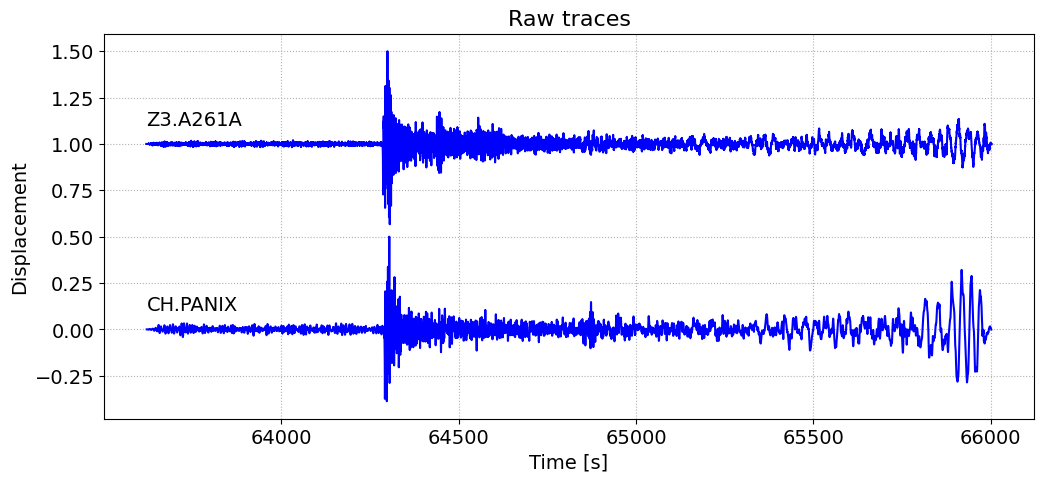

In [42]:
fig3, ax3 = SetupFigure(12, 5, "Time [s]", "Displacement", "Raw traces", 14)
plotTraceGather(rawlist, ax3)

#### Task 1.3: Filter the data using a Butterworth low pass with fc=0.5 Hz and order 6. 

Use either the provided function for the low-pass transfer function or take your own. First, Fourier transform the data, then multiply with the filter transfer function, and finally do the back transform. Create new SeismicTrace objects for the filtered traces, put them into a list and plot them.

In [43]:
fc = 0.5; order = 6
filtlist = []
for tr in rawlist:
    c = dft_fast_coeff(tr.vals)
    df = 1./tr.tlen
    hb = butterworth_lowpass(fc, df, c.size, order)
    fts = c*hb
    s = dft_fast_synthesis(fts, outnum='even')
    trfil = SeismicTrace(tr.staname, tr.comp, tr.dt, tr.tanf, s)
    filtlist.append(trfil)

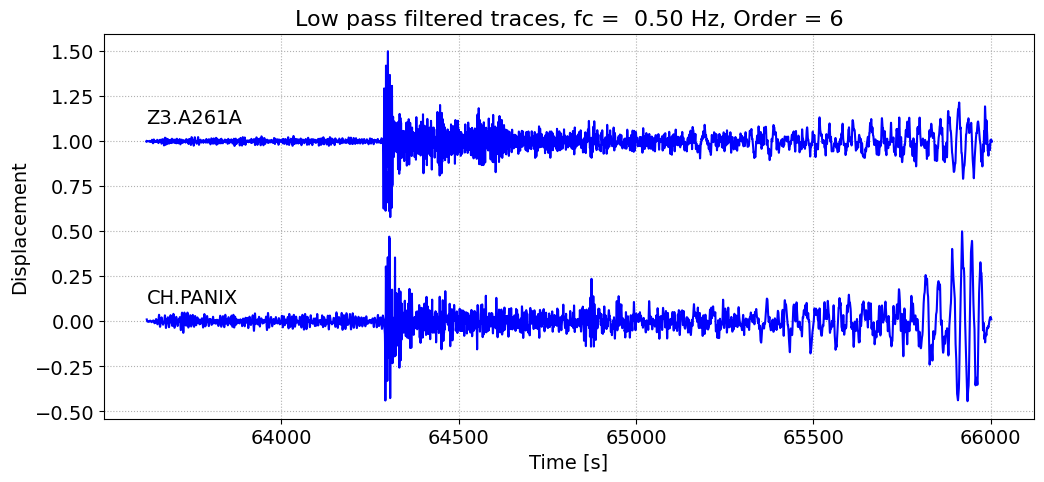

In [44]:
fig4, ax4 = SetupFigure(12, 5, "Time [s]", "Displacement", "Low pass filtered traces, fc = {:5.2f} Hz, Order = {:d}".format(fc, order), 14)
plotTraceGather(filtlist, ax4)

####  Task 1.4: Cut out the P-wave train from the recordings. Try different time windows for each trace. 

As a start, use the times [64285, 64300] for CH.PANIX and the times [64280, 64295] for Z3.A261A. For cutting out samples, proceed as follows: (1) Calculate the sample indices for the beginning and end of the window, (2) calculate the new starting time, (3) create a new SeismicTrace object with same station name, component and DT but adjusted start time (tanf) and the data values within the
precalculated index range. (4) Again, put the windowed seismograms into a list.

In [45]:
winlist = [[64285, 64300], [64280, 64295.1]]
cutlist = []
for j, tr in enumerate(filtlist):
    win = winlist[j]
    jfirst = int((win[0]-tr.tanf)/tr.dt)
    jlast = int((win[1]-tr.tanf)/tr.dt)
    nsamp = jlast-jfirst
    tanew = jfirst*tr.dt+tr.tanf
    print(tr.tanf, tanew, jfirst, jlast)
    cuttr = SeismicTrace(tr.staname, tr.comp, tr.dt, tanew, tr.vals[jfirst:jlast])
    cutlist.append(cuttr)

63621.435001 64284.985010289696 13271 13571
63620.15 64279.9500092372 13196 13498


#### Task 1.5: Plot the windowed traces using plotTraceGather.

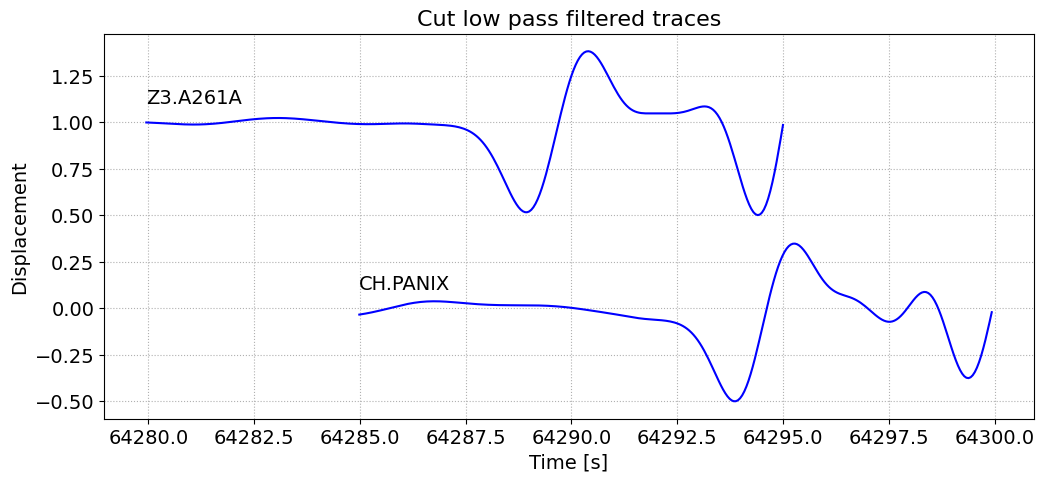

In [46]:
fig5, ax5 = SetupFigure(12, 5, "Time [s]", "Displacement", "Cut low pass filtered traces".format(fc, order), 14)
plotTraceGather(cutlist, ax5)

#### Task 1.6: Cross-correlate the windowed seismograms and compute the time delay

Compute the correlation for delays from -500 to +500 samples. To get the time delay, search the index jmax of the maximum of the cross-correlation. Since sample zero of the cross-correlation belongs to a time of -500*dt, the time delay is given by $\tau=(jmax-500)dt$. This is correct if the start times of the traces are identical. If not, we must correct for the start time difference. For example, if you correlate PANIX with A261A in this order, you obtain the delay of PANIX relative to A261A which is given by $\tau$ + ta(PANIX)-ta(A261A).

Print the index of the CC maximum, print the start times of the traces and print the time delay. Does the result meet your expectations from the figure of Task 1.5?

In [47]:
dt = cutlist[0].dt
tadiff = cutlist[0].tanf-cutlist[1].tanf
neglim = -500; poslim = 500
t, cc = crossCorrelation(cutlist[0].vals, cutlist[1].vals, dt, neglim, poslim)
delay = (np.argmax(cc)+neglim)*dt+tadiff
print("Tanf_0 = ", cutlist[0].tanf, "Tanf_1 = ", cutlist[1].tanf, "Index of max cc: ", np.argmax(cc)+neglim)
print("Delay of ", cutlist[0].staname," relative to ", cutlist[1].staname,":", delay)

Tanf_0 =  64284.985010289696 Tanf_1 =  64279.9500092372 Index of max cc:  -2
Delay of  CH.PANIX  relative to  Z3.A261A : 4.9350010510925895


#### Task 1.7: Plot the cross-correlation function

Use the true delay time on the x-axis of your plot. 

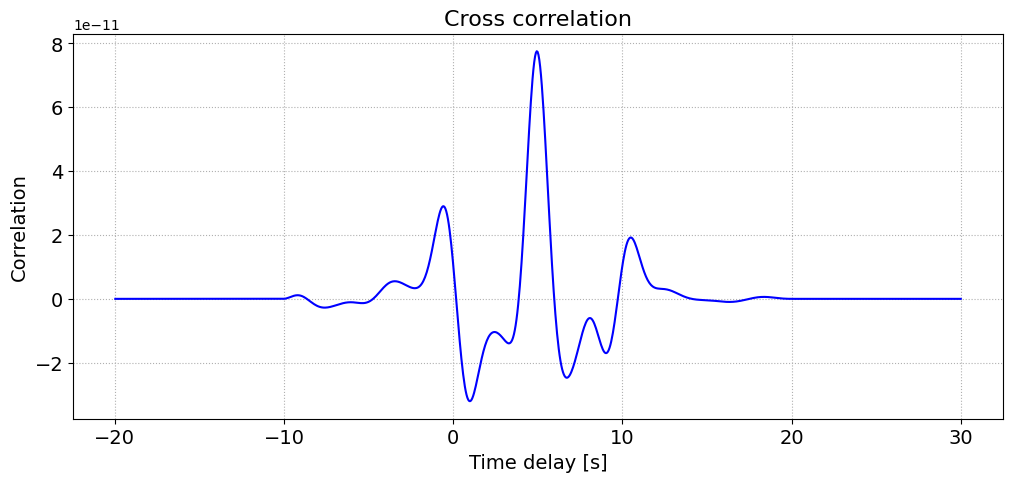

In [48]:
fig6, ax6 = SetupFigure(12, 5, "Time delay [s]", "Correlation", "Cross correlation", 14)
ax6.plot(t+tadiff, cc, color='blue', ls='-')

#### Task 1.8: Compute the energy and rms of the windowed data of each trace

The energy of the trace is given by E=$\int s^2(t)dt$. The square root of the energy is the root-mean-square (rms).

In [49]:
energy = []
rms = []
for tr in cutlist:
    en = np.dot(tr.vals, tr.vals)*dt
    energy.append(en)
    rms.append(np.sqrt(en))
print(energy)
print(rms)

[np.float64(5.0296662841061636e-11), np.float64(1.282390565577697e-10)]
[np.float64(7.092014018673513e-06), np.float64(1.1324268477820972e-05)]


#### Task 1.9: Normalize the cross correlation function by the rms values of the correlated traces and plot it.

In [50]:
ccnorm = cc/(rms[0]*rms[1])

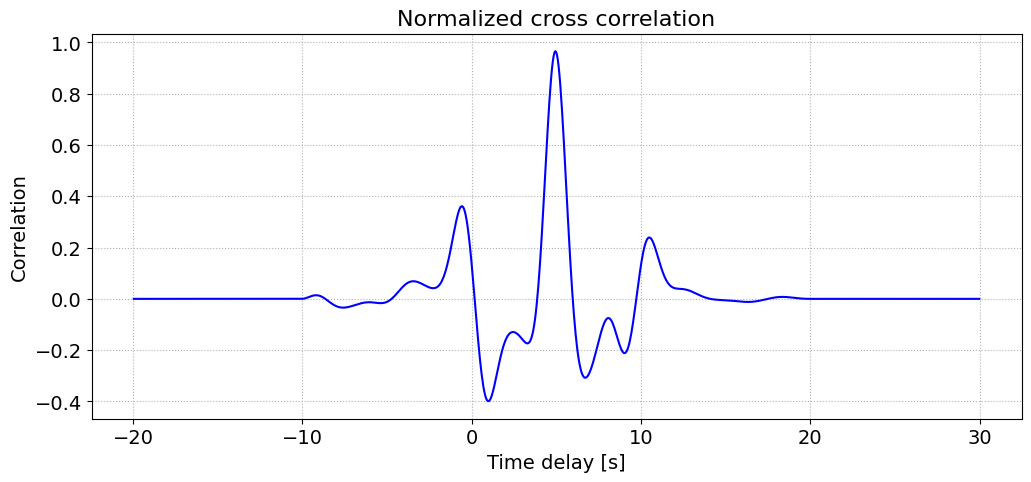

In [51]:
fig7, ax7 = SetupFigure(12, 5, "Time delay [s]", "Correlation", "Normalized cross correlation", 14)
ax7.plot(t+tadiff, ccnorm, color='blue', ls='-')